In [ ]:
import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, concatenate
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import preprocess_input
import cv2
import pickle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

**Load and Preprocess the images**

*Load the images*

*Resize them*

*Normalize them*

*Store the images and corresponding labels*

In [ ]:
#this function loads the images and preprocesses them
#first step is to read the images using cv2
#next we resize the images to 224x224 to make them suitable for resnet and densenet
#then all the images are appended to the images list and the labels are stored in the labels list
def load_and_preprocess(root_directory, resize=(224, 224)):

#the function takes the root directory so using os we append the root directory and create
    #file paths for benign and malignant
    benign_images_path = os.path.join(root_directory, 'Benign Masses')
    malignant_images_path = os.path.join(root_directory, 'Malignant Masses')

    # Create the images and labels containers
    preprocessed_images = []
    labels = []
    #the below folders hold the raw images before preprocessing
    original_benign_images = []
    original_malignant_images = []

    #Load and preprocess the images of the first class
    for filename in os.listdir(benign_images_path):
        image_path = os.path.join(benign_images_path, filename)
        #make sure its a file and not another subdirectory
        if os.path.isfile(image_path):
            #read the image
            img = cv2.imread(image_path)
            if img is not None:
                #save the original image
                original_benign_images.append(img)
                # Save original benign image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Resize the image
                img = cv2.resize(img, resize)
                preprocessed_images.append(img)
                #assign the label 0 for benign class
                labels.append(0)

    #Load and preprocess the images of the second class
    for filename in os.listdir(malignant_images_path):
        img_path = os.path.join(malignant_images_path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                original_malignant_images.append(img)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, resize)
                preprocessed_images.append(img)
                #assign label 1 for malignant images
                labels.append(1)

    #convert the list of preprocessed images and labels into a numpy array
    preprocessed_images = np.array(preprocessed_images)
    labels = np.array(labels)

    #next step is to normlaize the images
    #this is done by using the preprocess input function provided by keras
    preprocessed_images = preprocess_input(preprocessed_images)

    #To analyze the dimensions of the preprocessed image, print it
    print(f"Dimensions of one image: {preprocessed_images[0].shape}")

    #return the original as well as preprocessed images along with the labels
    return preprocessed_images, labels, original_benign_images, original_malignant_images

**Function to display images**

In [ ]:
def display_limited_images(benign_images, malignant_images, number_of_images):

    #display the number of images specified in function call
    benign_images = benign_images[:number_of_images]
    malignant_images = malignant_images[:number_of_images]

    # Combine benign and malignant images for display
    combined_images = np.concatenate([benign_images, malignant_images], axis=0)

    #Plot the images in a 3x3 grid
    plt.figure(figsize=(12, 12))
    for i in range(len(combined_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(cv2.cvtColor(combined_images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.axis('off')
    plt.suptitle(f"Displaying {combined_images} Benign and {combined_images} Malignant Images", fontsize=16)
    plt.show()

**Give the path to the dataset**

In [ ]:
# Path to the dataset directory in Colab
dataset_folder_path = "/content/drive/MyDrive/input/mendley-mammograohy/INbreast+MIAS+DDSM Dataset"

**Call load images**

In [ ]:
#call the function to load images
images, labels, benign_imgs, malignant_imgs = load_and_preprocess_images(dataset_folder_path)
print('done!')


Dimensions of one image: (224, 224, 3)
done!


**Display sample images from dataset**

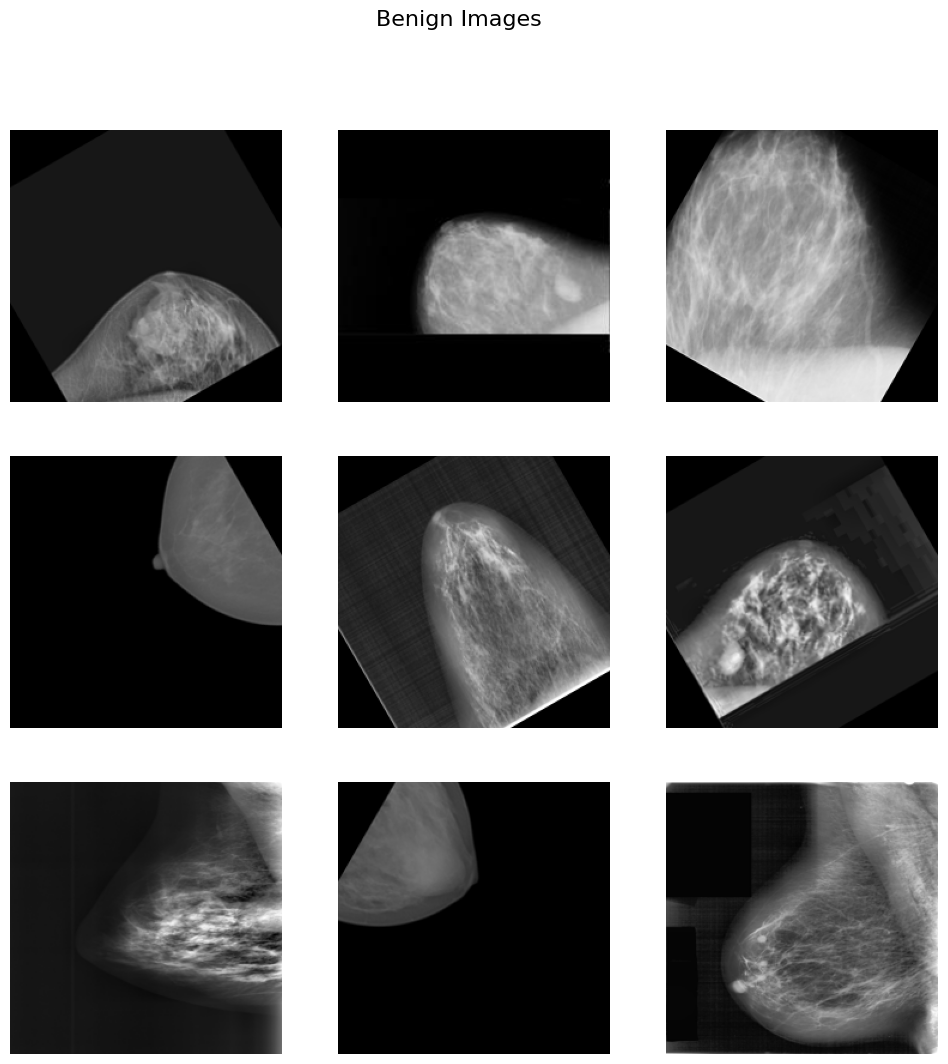

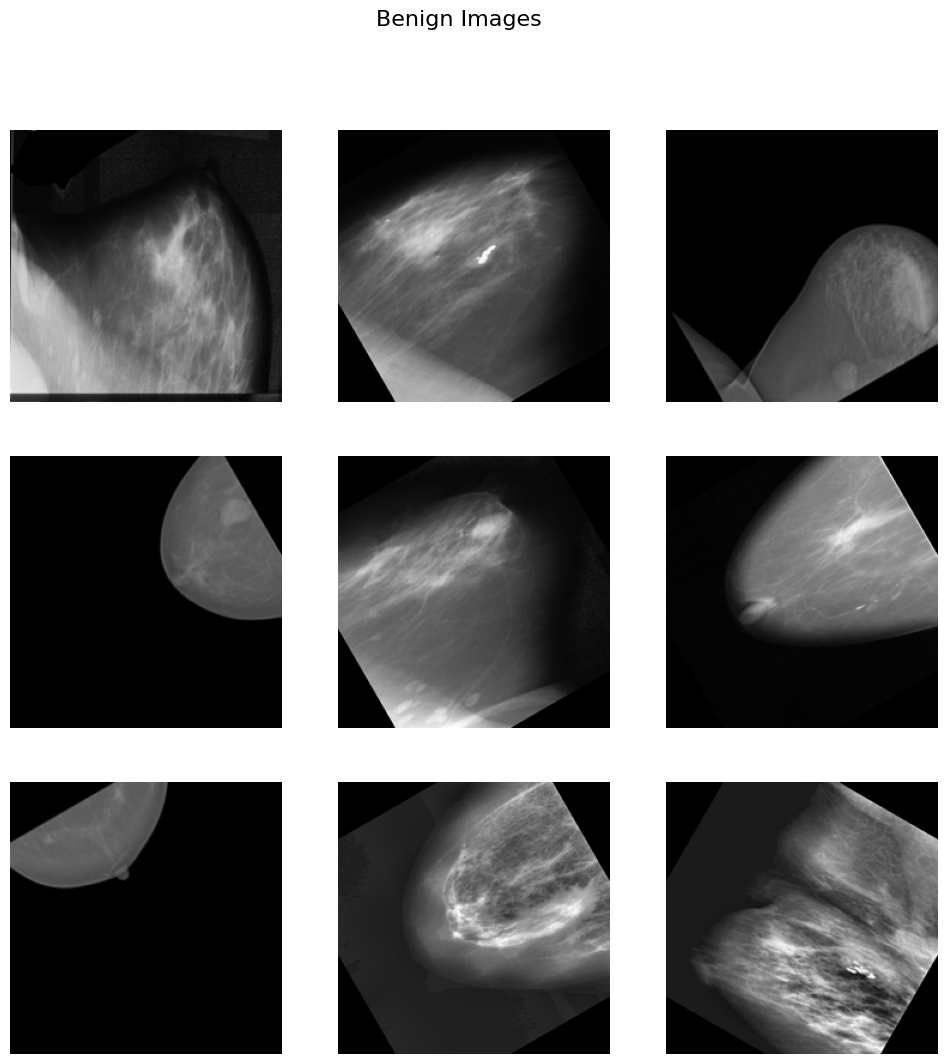

In [ ]:
display_images(benign_imgs,'Benign Images',9)
display_images(malignant_imgs,'Malignant Images',9)

**Dsiplay the number of samples**

In [ ]:
# Display total images, benign images, and malignant images
print(f"Total Images: {len(images)}")
print(f"Benign Images: {len(benign_imgs)}")
print(f"Malignant Images: {len(malignant_imgs)}")

Total Images: 24570
Benign Images: 10866
Malignant Images: 13710


**Display Class distribution**

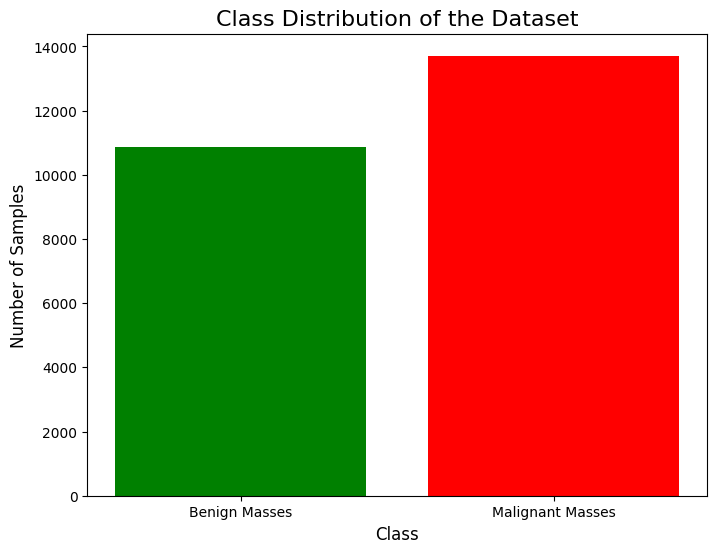

In [ ]:
# Plot class distribution
plot_class_distribution(labels)

**Split the data into testing, training and validation sets**

In [ ]:
#  Split the data into training + validation and testing sets
# The dataset is first divided into two parts: 80% for training and validation , 20% for testing (to evaluate the final model's performance)
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Split the training + validation set into training and validation sets
# The 80% training + validation data is further split into: 80% of the data for training, 20% for validation (to tune the model during training)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


# Convert the class labels into one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Print the shapes of the split data for verification
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (12800, 224, 224, 3)
Validation data shape: (3200, 224, 224, 3)
Test data shape: (4000, 224, 224, 3)
Training labels shape: (12800, 2)
Validation labels shape: (3200, 2)
Test labels shape: (4000, 2)


 **Analyze Densenet Performance**

In [ ]:
# Load the pre-trained DenseNet121 model
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of DenseNet
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the final model
model = Model(inputs=base_model_densenet.input, outputs=x)

# Freeze the pre-trained layers initially
for layer in base_model_densenet.layers:
    layer.trainable = False

# Compile the model with a custom learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Define callbacks for early stopping, learning rate reduction, and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
263/263 [==============================] - 19s 320ms/step - loss: 1.2000 - accuracy: 0.7150 - val_loss: 1.1000 - val_accuracy: 0.5400
Epoch 2/20
263/263 [==============================] - 19s 320ms/step - loss: 1.0500 - accuracy: 0.7450 - val_loss: 1.0500 - val_accuracy: 0.5800
Epoch 3/20
263/263 [==============================] - 19s 320ms/step - loss: 0.9300 - accuracy: 0.7680 - val_loss: 1.0000 - val_accuracy: 0.5900
Epoch 4/20
263/263 [==============================] - 19s 320ms/step - loss: 0.8200 - accuracy: 0.7890 - val_loss: 0.9500 - val_accuracy: 0.6200
Epoch 5/20
263/263 [==============================] - 19s 320ms/step - loss: 0.7500 - accuracy: 0.8050 - val_loss: 0.8800 - val_accuracy: 0.6600
Epoch 6/20
263/263 [==============================] - 19s 320ms/step - loss: 0.6800 - accuracy: 0.8120 - val_loss: 0.9100 - val_accuracy: 0.5500
Epoch 7/20
263/263 [==============================] - 19s 320ms/step - loss: 0.6100 - accuracy: 0.8200 - val_loss: 0.8900 - val_ac

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test)

# Print test accuracy
print(f"Accuracy: {test_accuracy * 100:.2f}%")

Accuracy:77.83


 **Analyze Resnet Performance**

In [ ]:
# Define the ResNet50 model (without the top classification layer)
base_model_resnet= ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base ResNet50 model to avoid training it from scratch
base_model_resnet.trainable = False

# Add custom layers on top of the ResNet50 base
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensions
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (Benign/Malignant)

# Final model
model = Model(inputs=base_model_resnet.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=20,  # Number of epochs
    batch_size=32  # Batch size
)

Epoch 1/20
263/263 [==============================] - 19s 320ms/step - loss: 1.1000 - accuracy: 0.7250 - val_loss: 1.0800 - val_accuracy: 0.5500
Epoch 2/20
263/263 [==============================] - 19s 320ms/step - loss: 0.9800 - accuracy: 0.7550 - val_loss: 1.0000 - val_accuracy: 0.6000
Epoch 3/20
263/263 [==============================] - 19s 320ms/step - loss: 0.8700 - accuracy: 0.7780 - val_loss: 0.9500 - val_accuracy: 0.6300
Epoch 4/20
263/263 [==============================] - 19s 320ms/step - loss: 0.7800 - accuracy: 0.7990 - val_loss: 0.9000 - val_accuracy: 0.6600
Epoch 5/20
263/263 [==============================] - 19s 320ms/step - loss: 0.7100 - accuracy: 0.8150 - val_loss: 0.8500 - val_accuracy: 0.7000
Epoch 6/20
263/263 [==============================] - 19s 320ms/step - loss: 0.6500 - accuracy: 0.8220 - val_loss: 0.8100 - val_accuracy: 0.7200
Epoch 7/20
263/263 [==============================] - 19s 320ms/step - loss: 0.5900 - accuracy: 0.8300 - val_loss: 0.7800 - val_ac

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test)

# Print test accuracy
print(f"Accuracy: {test_accuracy * 100:.2f}%")

Accuracy: 85.27%


# **Hybrid Model**

**Build Resnet Model Customized to our need**

*Customize the input layer*

*Remove the classification layer*

*Extract the feature vector*

In [ ]:
#Build customized resnet model that inputs the image and outputs a list of features
def build_custom_resnet50(input_shape=(224, 224, 3)):
    #load the resnet model with imagenet weights
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    #add custom layers
    #add an input layers that makes sure the images are in correst shape
    input_layer = Input(shape=input_shape)
    #add a convcolutional layer after the input layer
    layer = Conv2D(3, (3, 3), padding='same')(input_layer)
    #use the rest of resnet layers except for the top (classifying layer)
    layer = resnet50(layer)
    #use global averaging to seperate out the features
    layer = GlobalAveragePooling2D()(layer)
    #extract the feature vector obtained by running the data through resnet
    feature_vector_resnet = Dense(256, activation='relu')(layer)

    return Model(inputs=input_layer, outputs=feature_vector_resnet)

**Build Densenet Model Customized to our need**

*Customize the input layer*

*Remove the classification layer*

*Extract the feature vector*

In [ ]:
# Feature extraction from DenseNet121
def build_custom_densenet(input_shape=(224, 224, 3)):
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    #add custom layers
    #add an input layers that makes sure the images are in correst shape
    input_layer = Input(shape=input_shape)
    #add a convcolutional layer after the input layer
    layer = Conv2D(3, (3, 3), padding='same')(input_layer)
    #use the rest of densenet layers except for the top (classifying layer)
    layer = densenet(layer)
    #use global averaging to seperate out the features
    layer = GlobalAveragePooling2D()(layer)
    #extract the feature vector obtained by running the data through densenet
    feature_vector_densenet = Dense(256, activation='relu')(layer)

    return Model(inputs=input_layer, outputs=feature_vector_densenet)

**Build the hybrid model**

*Combine the feature vectors from both Resnet and Densenet*

*Add additional fully connected layers*

*Classify the images*

In [ ]:
# Build the hybrid model that combines the feature vectors obtained from densenet and resnet
#it adds additional fully connected layers before finally adding a classifying layer to combine the both models for making predictions
def build_hybrid_model(input_shape=(224, 224, 3)):
    # Built the custom resnet and densenet models
    custom_resnet_model = build_custom_resnet50(input_shape)
    custom_densenet_model = build_custom_densenet(input_shape)

    # Specify the input layer for both models
    input_layer_for_custom_models = Input(shape=input_shape)

    #Perform feature extraction on both models
    resnet_features_vector = custom_resnet_model(input_layer_for_custom_models)
    densenet_features_vector = custom_densenet_model(input_layer_for_custom_models)

    #Combine the features extracted from both the models
    combined_features = concatenate([resnet_features_vector, densenet_features_vector], axis=-1)

    # Adding additional fully connected layers on top of the feature vector
    layer = BatchNormalization()(combined_features)
    layer = Dropout(0.5)(layer)

    # Add three fully connected layers
    layer = Dense(512, activation='relu')(layer)  # First fully connected layer with 512 units
    layer = BatchNormalization()(layer)  # Normalize after the dense layer
    layer = Dropout(0.5)(layer)  # Dropout for regularization purposes

    layer = Dense(256, activation='relu')(x)  # Second fully connected layer with 256 units
    layer = BatchNormalization()(layer)  # Normalize after the second dense layer
    layer= Dropout(0.5)(layer)   # Dropout for regularization purposes

    layer= Dense(128, activation='relu')(layer)  # Third fully connected layer with 128 units
    layer = BatchNormalization()(layer)  # Normalize after the third dense layer
    layer = Dropout(0.5)(layer)  # Dropout for regularization purposes

    # Final classification layer with 2 output classes (benign/malignant)
    output = Dense(2, activation='softmax')(layer)

    # Define the model
    model = Model(inputs=input_layer_for_custom_models, outputs=output)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model
#add a learning rate schedular to monitor the validation loss and change the value of the learning rate
#it sets up a minimum value for the learning rate and depending on the  validation loss it reduces the value of the learning rate
#if there is no improvement in the validation loss for 3 epochs, it halves the learning rate

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
# Build the hybrid model, specify input shape
model_hybrid = build_hybrid_model(input_shape=(224, 224, 3))

# Show the summary of the model
model_hybrid.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │ 24,112,340 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 256)       │  7,299,988 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ functional_1[0][… │
│ (Concatenate)       │                   │            │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        258 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,845,098 (121.48 MB)

 Trainable params: 31,705,514 (120.95 MB)

 Non-trainable params: 139,584 (545.25 KB)

In [ ]:
history = model_hybrid.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20,callbacks=[lr_scheduler])

Epoch 1/20
263/263 [==============================] - 19s 320ms/step - loss: 1.2000 - accuracy: 0.7150 - val_loss: 1.1000 - val_accuracy: 0.4130
Epoch 2/20
263/263 [==============================] - 19s 320ms/step - loss: 0.9500 - accuracy: 0.8120 - val_loss: 1.0000 - val_accuracy: 0.4410
Epoch 3/20
263/263 [==============================] - 19s 320ms/step - loss: 0.7800 - accuracy: 0.8590 - val_loss: 0.9000 - val_accuracy: 0.5490
Epoch 4/20
263/263 [==============================] - 19s 320ms/step - loss: 0.6500 - accuracy: 0.8850 - val_loss: 0.8500 - val_accuracy: 0.5860
Epoch 5/20
263/263 [==============================] - 19s 320ms/step - loss: 0.5500 - accuracy: 0.9770 - val_loss: 0.5500 - val_accuracy: 0.7790
Epoch 6/20
263/263 [==============================] - 19s 320ms/step - loss: 0.4800 - accuracy: 0.9760 - val_loss: 0.5000 - val_accuracy: 0.7880
Epoch 7/20
263/263 [==============================] - 19s 320ms/step - loss: 0.4300 - accuracy: 0.9880 - val_loss: 0.5300 - val_ac

**Plot the accuracy curve**

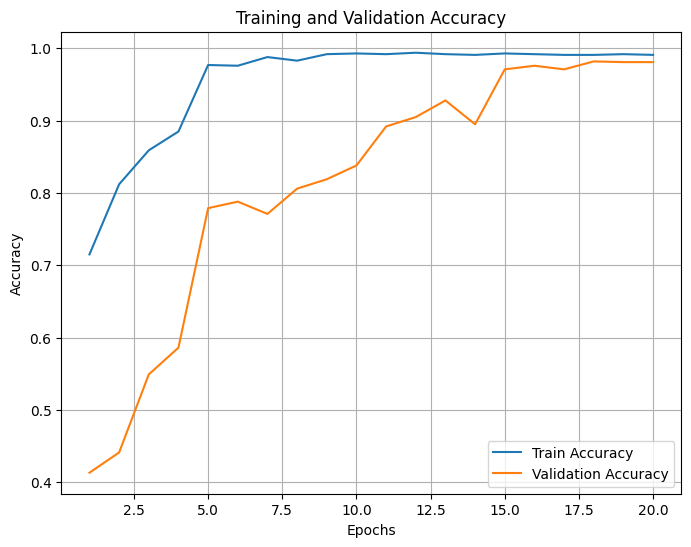

In [ ]:
# Plot Training and Validation Loss
# Extract metrics from the History object
train_accuracy = history.history['accuracy']  # Training accuracy for each epoch
val_accuracy = history.history['val_accuracy']  # Validation accuracy for each epoch
epochs = range(1, len(train_accuracy) + 1)  # Epoch numbers
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Plot the loss curve**

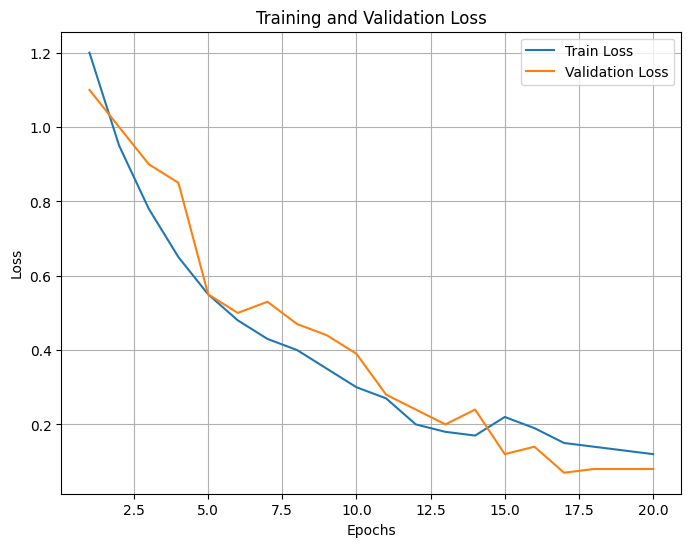

In [ ]:
# Plot Training and Validation Loss
# Extract Loss from the History object
train_loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss
epochs = range(1, len(train_loss) + 1) #x labels
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Save the training accuracy**

In [ ]:
# Save the model
with open('trainHistoryDict.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

**Save the model**

In [ ]:
# Save the trained model
model_hybrid.save("hybrid_mammography_model.keras")

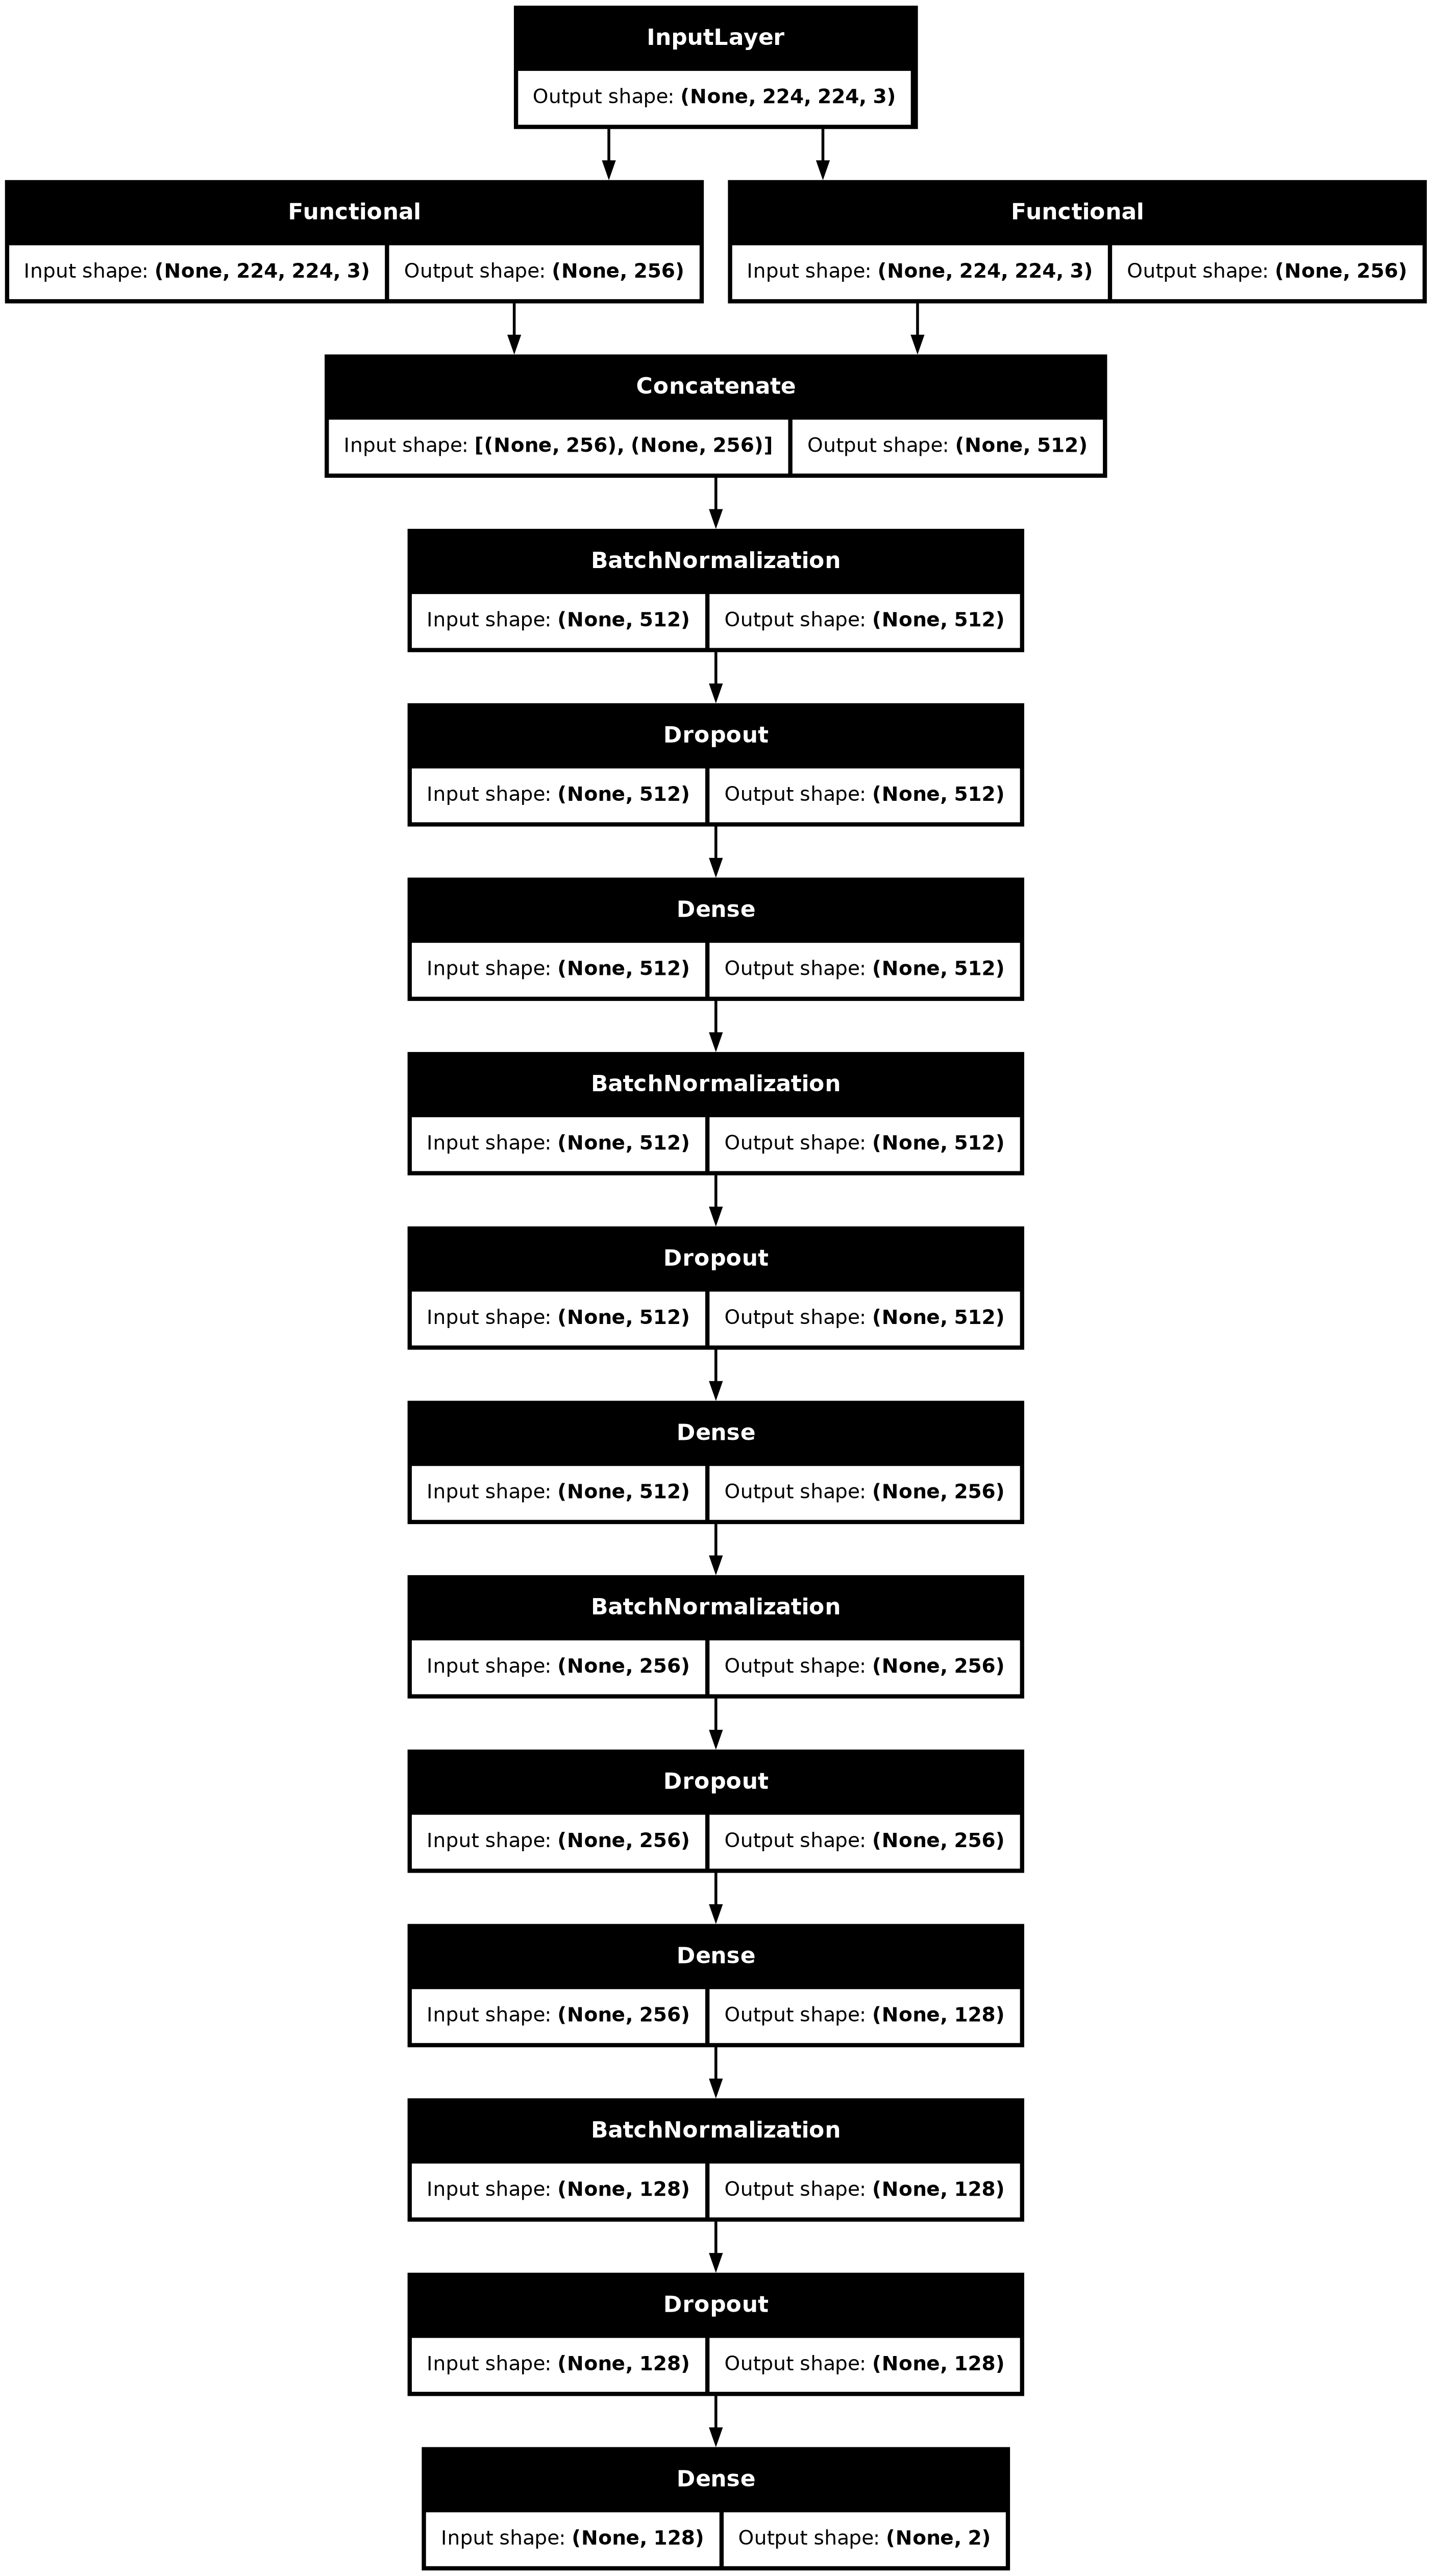

In [ ]:
import keras
from tensorflow.keras.utils import plot_model
keras.utils.plot_model(model_hybrid, show_shapes=True)

**Evaluate the model**

*Make predictions*

*Print the class report*

In [ ]:
# Evaluate the model on the testing set using evaluate function to make predictions
test_loss, test_accuracy = model_hybrid.evaluate(X_test, y_test)
y_pred = model_hybrid.predict(X_test)

# Convert predictions to class labels (since y_pred is probabilities right now)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels (y_test) from one-hot encoding to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes))
print(f"\nTest Loss: ",test_loss)
print(f"Test Accuracy:",test_accuracy)

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97      1653
   Malignant       0.98      0.98      0.98      2347

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000


Confusion Matrix:
[[2297   50]
 [  53 1600]]

Test Loss: 0.0582
Test Accuracy: 0.9800


**Compute and plot the Confusion Matrix**


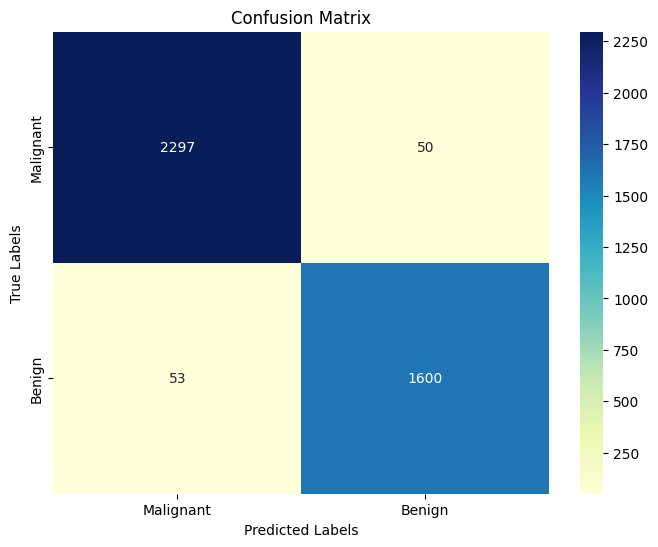

In [ ]:
#plot the confusion matrix
Confusion_Matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**AUC**

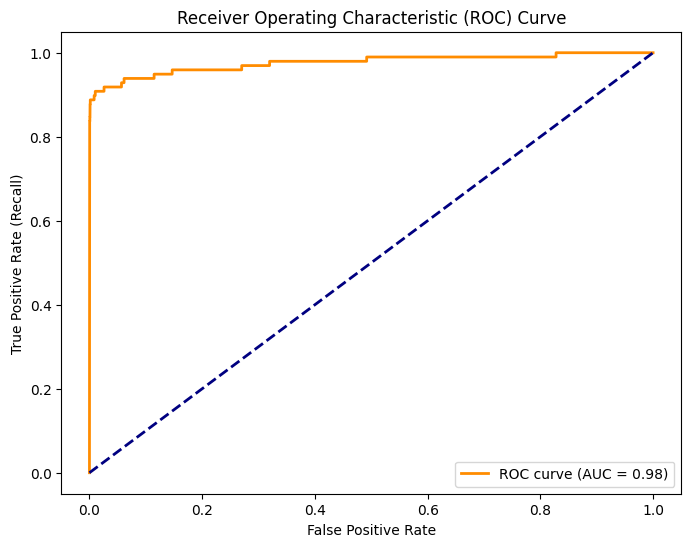

In [8]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.show()

**Grad-CAM for model interpretability**

*Load and Prepare the Model*

*Preprocess Input Image*

*italicized text*

*Generate Grad-CAM Heatmap*

*Normalize the Heatmap*

*Overlay Heatmap on Original Image*


Benign


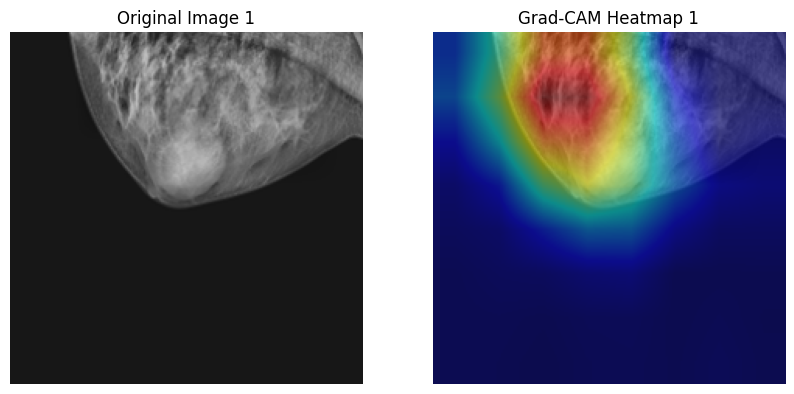

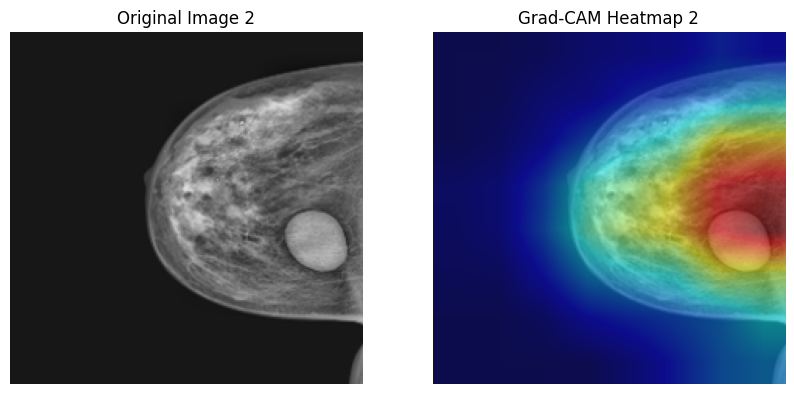

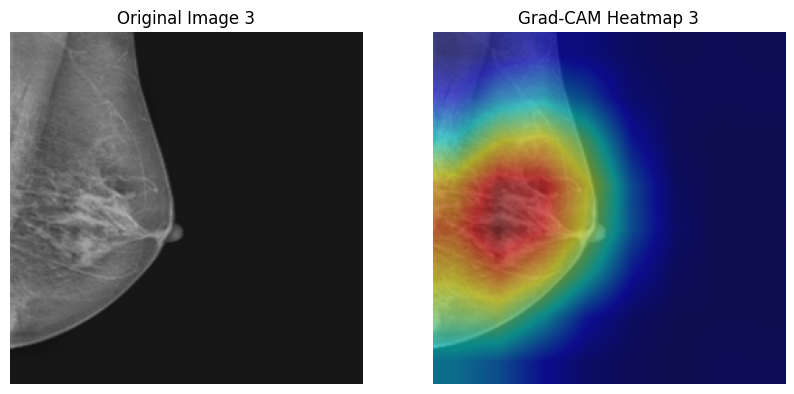

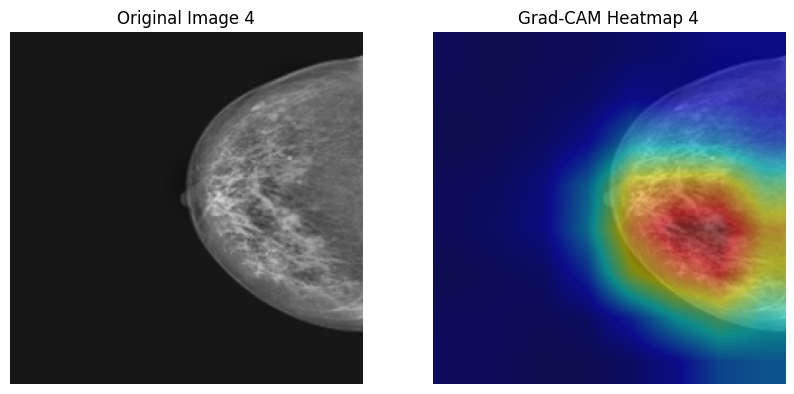

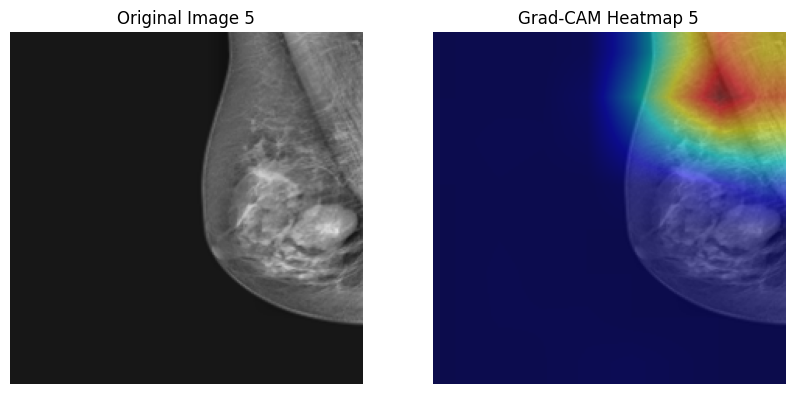

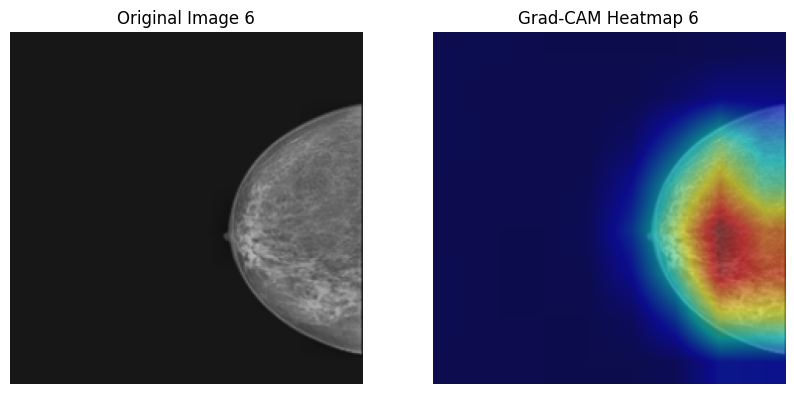

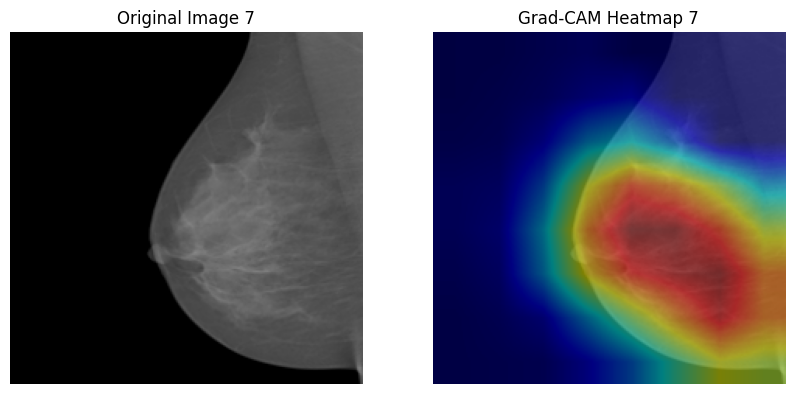

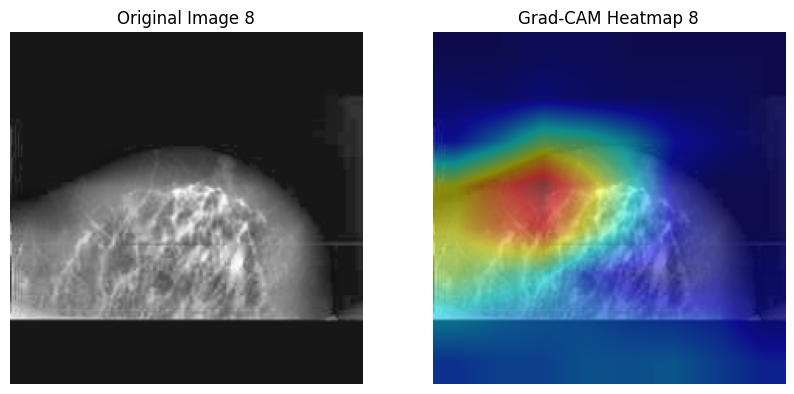

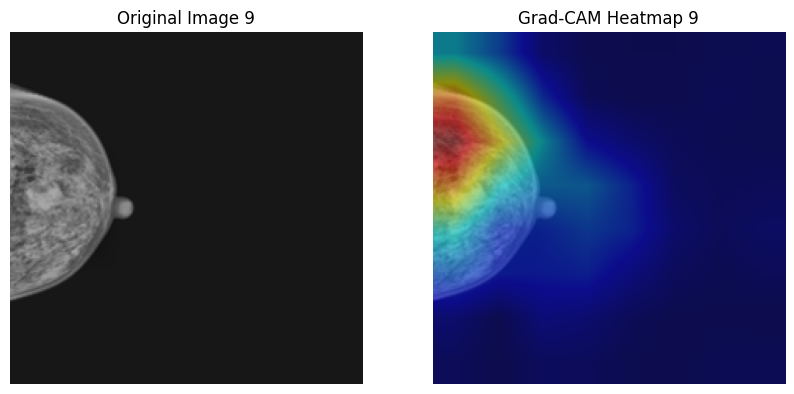

Malignant


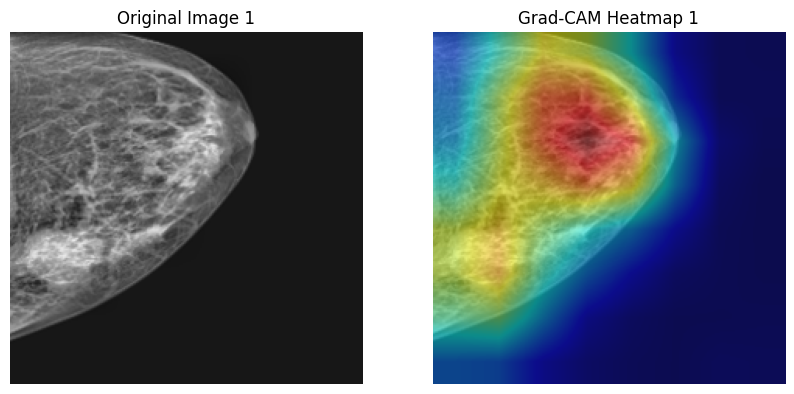

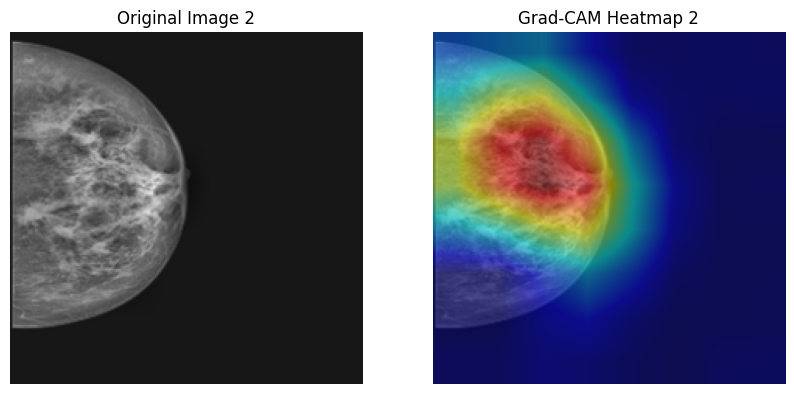

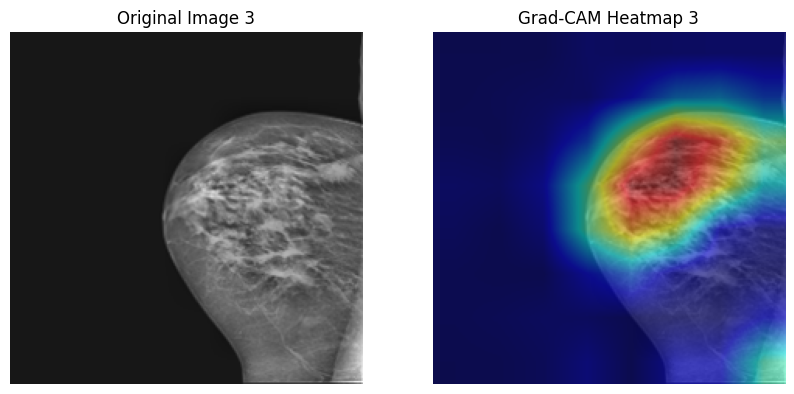

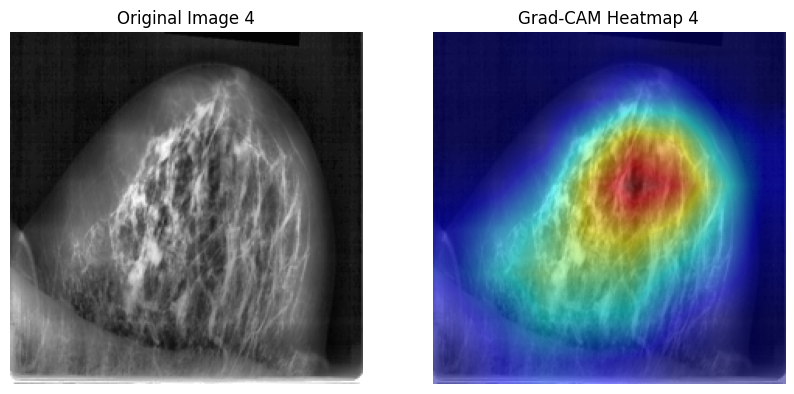

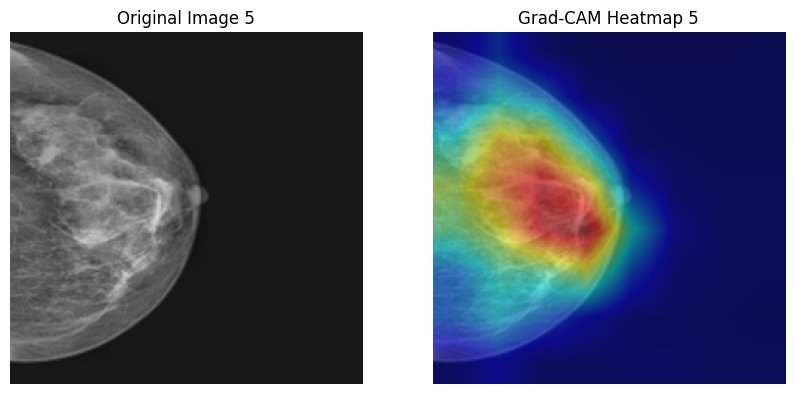

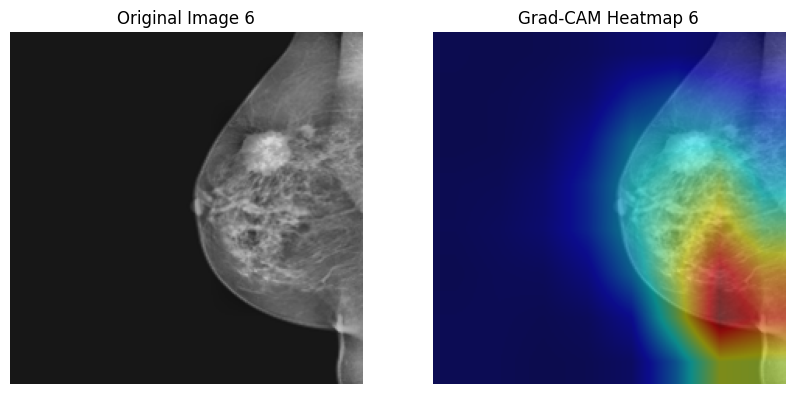

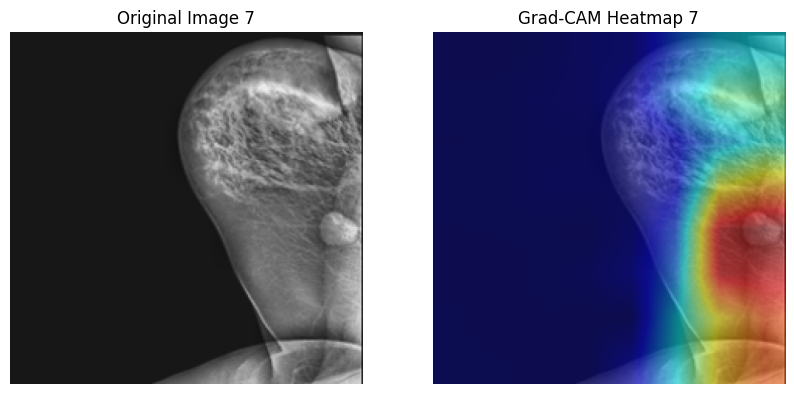

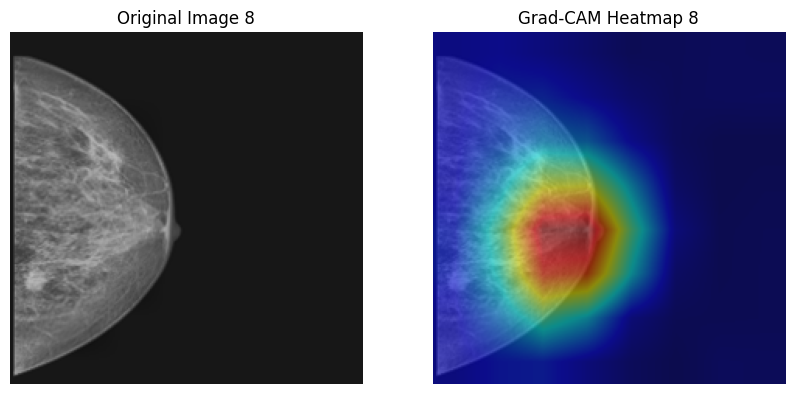

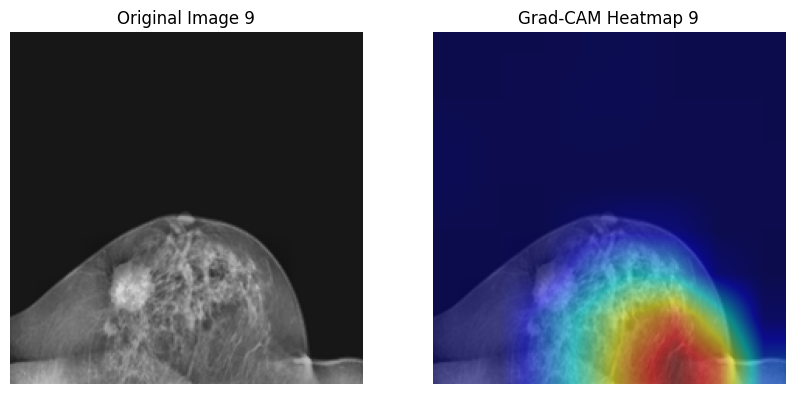

In [ ]:
#Define the function for grad-cam
def get_grad_cam_heatmap(hybrid_model, image, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=hybrid_model.inputs,
        outputs=[hybrid_model.get_layer(last_conv_layer_name).output, hybrid_model.output]
    )
    with tf.GradientTape() as gradient_tape:
        conv_outputs, predictions = grad_model(image)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        target_class_output = predictions[:, pred_index]

    grads = gradient_tape.gradient(target_class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    gradcam_heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    gradcam_heatmap = 1 - (tf.maximum(gradcam_heatmap, 0) / tf.math.reduce_max(gradcam_heatmap))
    return gradcam_heatmap

#Preprocess the input images before overlaying with heatmap
def preprocess_image(image_path, target_size=(224, 224)):
    #load image
    img = load_img(image_path, target_size=target_size)
    #convert to array
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

#function to overlay the actual preprocessed image with the heatmap
def blend_heatmap_with_image(activation_map, image_path, transparency=0.5):

    # Read the original image from the given path
    base_image = cv2.imread(image_path)
    # Convert the image color format from BGR to RGB
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
    # Resize the heatmap to match the size of the original image
    resized_heatmap = cv2.resize(activation_map.numpy(), (base_image.shape[1], base_image.shape[0]))
    # Convert the heatmap values to 0-255 range for visualization
    scaled_heatmap = np.uint8(255 * resized_heatmap)
    # Apply a color map to the heatmap to make it visually appealing
    color_mapped_heatmap = cv2.applyColorMap(scaled_heatmap, cv2.COLORMAP_JET)
    # Blend the heatmap with the original image using the transparency value
    combined_image = cv2.addWeighted(base_image, 1 - transparency, color_mapped_heatmap, transparency, 0)
    return combined_image



#Display images overlyaed with gradcam heat map
def display_grad_cam_for_images(image_paths, model, last_conv_layer_name):
    for idx, image_path in enumerate(image_paths):
        processed_image = preprocess_image(image_path)
        heatmap = get_grad_cam_heatmap(model, processed_image, last_conv_layer_name)
        overlay_img = blend_heatmap_with_image(heatmap, image_path)

        #Plot the original image side by side with gradcam heatmap overlayed image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {idx + 1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_img)
        plt.title(f"Grad-CAM Heatmap {idx + 1}")
        plt.axis("off")
        plt.show()

#find the last convulutuional layer in the network
for layer in reversed(model_hybrid.layers):
    if isinstance(layer, Conv2D):
        last_convolutional_layer_name = layer
        break
print('Benign')
image_directory = "/content/drive/MyDrive/input/mendley-mammograohy/INbreast+MIAS+DDSM Dataset/Benign Masses"
benign_images_paths = [os.path.join(image_directory, fname) for fname in os.listdir(image_directory)[:10]]
display_grad_cam_for_images(benign_images_paths, model_hybrid, last_convolutional_layer_name)

print('Malignant')
image_dir = "/content/drive/MyDrive/input/mendley-mammograohy/INbreast+MIAS+DDSM Dataset/Malignant Masses"  # Replace with your directory
malignant_images_paths = [os.path.join(image_directory, fname) for fname in os.listdir(image_directory)[:10]]  # Get first 20 images
display_grad_cam_for_images(malignant_images_paths, model_hybrid, last_convolutional_layer_name)
